In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Loading the Datasets

In [7]:
transactions=pd.read_csv('Transactions.csv')

In [8]:
customers=pd.read_csv('Customers.csv')

Merging data on Customer ID

In [10]:
merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')

Extracting meaningful features from raw data

In [19]:
data = (
    merged_data.groupby('CustomerID')
    .agg(
        TotalTransactions=('TransactionID', 'count'),
        TotalSpending=('TotalValue', 'sum'),
        AverageSpending=('TotalValue', 'mean')
    )
    .reset_index()
)

In [20]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
data = pd.merge(data, customers[['CustomerID', 'Region', 'SignupDate']], on='CustomerID')
data['DaysSinceSignup'] = (pd.Timestamp.now() - data['SignupDate']).dt.days

Preprocessing

In [21]:
encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(data[['Region']]).toarray()
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))
data = pd.concat([data, region_encoded_df], axis=1)

In [22]:
processed_data = data.drop(['CustomerID', 'Region', 'SignupDate'], axis=1)

In [23]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

In [24]:
optimal_clusters = 0
lowest_db_index = np.inf

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, labels)
    if db_index < lowest_db_index:
        lowest_db_index = db_index
        optimal_clusters = n_clusters

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

In [25]:
silhouette = silhouette_score(scaled_data, data['Cluster'])

In [26]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
data['PCA1'] = reduced_data[:, 0]
data['PCA2'] = reduced_data[:, 1]

In [28]:
%pip install seaborn

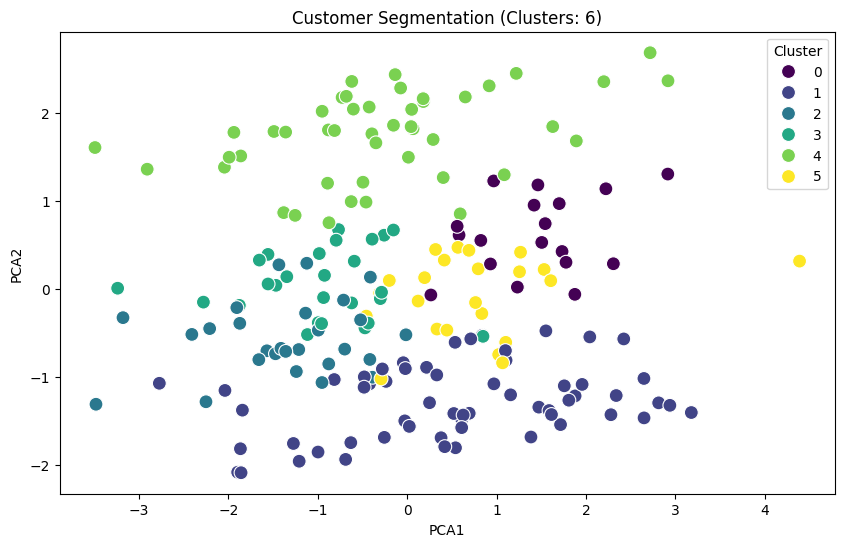

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis', s=100)
plt.title(f'Customer Segmentation (Clusters: {optimal_clusters})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [30]:
print("Davies-Bouldin Index:", lowest_db_index)
print("Silhouette Score:", silhouette)

Davies-Bouldin Index: 1.1182346408751787
Silhouette Score: 0.3403143458825825
